# **Resumen** 
Vamos a hacer uso de de una dataset con personas que tienen insuficiencia cardiaca. Vamos a agrupar y usar patrones frecuentes para determinar que tipos de personas son máás propensas a sufrir de insuficiencia cardiaca.

# Descripción de los datos

- age: Edad del paciente (años)
- anaemia: disminución de los glóbulos rojos o de la hemoglobin (boleano) 0=false(no tiene);1=true(si tiene)
- high blood pressure: Si el paciente tiene hipertensión (boleano) 0=false(no tiene);1=true(si tiene)
- creatinine phosphokinase (CPK): nivel de la enzima CPK en la sangre (mcg/L)
- diabetes: Sí el paciente tiene diabetes (boleano) 0=false(no tiene); 1=true(si tiene)
- ejection fraction: porcentaje de sangre que sale del corazón en cada contracción (porcentaje)
- platelets: plaquetas en la sangre (kiloplaquetas/mL)
- sex: Mujer o Hombre (binario) mujer=0; hombre=1
- serum creatinine: nivel de creatinina sérica en la sangre (mg/dL)
- serum sodium: nivel de sodio sérico en la sangre (mEq/L)
- smoking: Si el paciente fuma o no (boleano) 0=false(no fuma); 1=true(si fuma)
- time: período de seguimiento (días)
- [target] death event: si el paciente falleció durante el período de seguimiento (boleano) 0 = sobrevivio; 1 = muerto

Para más información de los datos consultar: [dataset](https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records#)

Paper de [Davide Chicco & Giuseppe Jurman](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5) con una explicación más amplía

In [1]:
#!pip install -U yellowbrick

     |████████████████████████████████| 276kB 5.4MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


# **INDICE**
> [Procesamiento de datos](#procesamiento)

> > [Elección de columnas para trabajo](#columnsw)

> [Clusterisación: K-Means](#kmeans)

>[Análisis de grupos](#analisis)

> [Experimentos](#serialexperimentslain)

In [2]:
#Cargamos las librerias que vamos a necesitar
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import numpy as np
from yellowbrick.cluster import silhouette_visualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

In [3]:
# Cargamos los datos con los que vamos a trabajar
heart_failure = pd.read_csv('/content/heart_failure_clinical_records_dataset.csv')

In [4]:
heart_failure.shape

(299, 13)

In [5]:
heart_failure.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


# Procesamiento

<a id="procesamiento"><h1><strong>Procesamiento de datos</strong></h1></a>

* **Corroborar que no hay datos nulos**

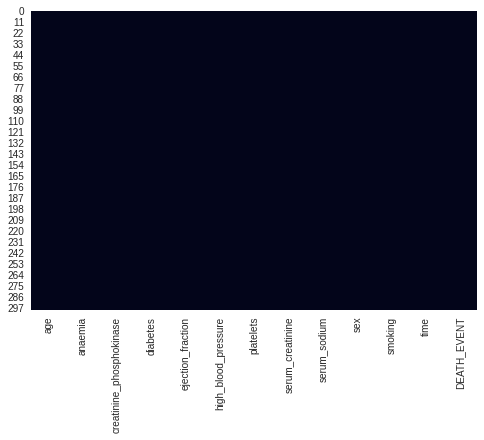

In [6]:
# ESTADO DE LOS DATOS
sns.heatmap(heart_failure.isnull(), cbar=False)

> A partir del mapa de calor podemos observar que no hay datos faltantes en nuestro conjunto de datos

## Elección de columnas

 <a id ="columnsw"><h1><strong>Elección de columnas para trabajo</strong></h1></a>

In [7]:
heart_failure.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

El corazón es un organo que su principal función es la de irrigar a todos los organos, cuando este no tiene la suficiente fuerza para bombear la sangre a eso se le llama insuficiencia cardiaca. Por lo tanto ¿qué tanta importancia tiene la diabetes aquí? Estamos estudiando fallas de corazón. Por lo tanto hemos de proceder a realizar una matriz de correlación

In [8]:

##No creo que ocupemos la columna time
#Aunque en la matriz de correlacion vemos que time y death_event estan inversamente correlacionadas
#otra cosa, si estamos estudiando fallas de corazon, Que tanta importancia tiene la diabetes?
#En la matriz de correlacion, la diabetes esta muy poco correlacionada con Death event

#heart_failure.drop(['time'],axis=1,inplace=True)

In [9]:
#heart_failure['time']=heart_failure['time']*-1

In [10]:
#heart_failure['ejection_fraction']=heart_failure['ejection_fraction']*-1

In [11]:
heart_failure.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


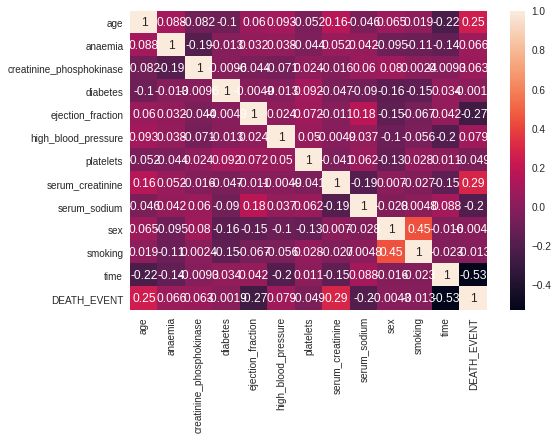

<Figure size 1440x1152 with 0 Axes>

In [12]:
#correlation_mat = heart_failure.corr().unstack()
R=heart_failure.corr()
#print(correlation_mat)
sns.heatmap(R, annot = True)
plt.figure(figsize=(20,16))
plt.show()

A partir de la matriz de correlación podemos filtrar los datos de trabajo. Tomamos los datos con una correlación mayor o igual a 0.25 con el evento de muerte. Por lo tanto los datos de trabajo son: 

- Age
- Ejection Fraction
- Serum Creatinine
- Time

In [13]:
heart_failure.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [14]:
eval = heart_failure[['age','ejection_fraction','serum_creatinine','time', 'DEATH_EVENT']]
eval.head()

,age,ejection_fraction,serum_creatinine,time,DEATH_EVENT
0,75.0,20,1.9,4,1
1,55.0,38,1.1,6,1
2,65.0,20,1.3,7,1
3,50.0,20,1.9,7,1
4,65.0,20,2.7,8,1


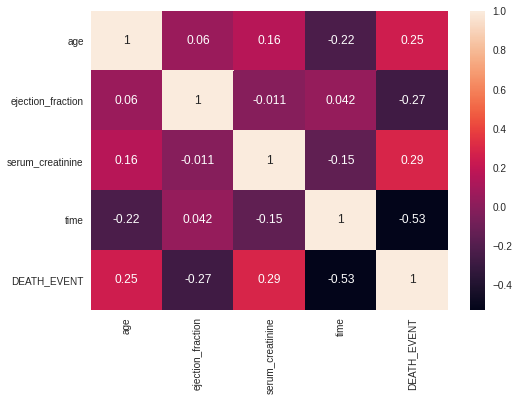

<Figure size 576x396 with 0 Axes>

In [15]:
R_eval=eval.corr()
sns.heatmap(R_eval, annot = True)
plt.figure()
plt.show()

# Clusterisación


<a id="kmeans"><h1><strong>Clusterisación: K-Means</strong></h1></a>

## **K-means y la elección efectiva de K**

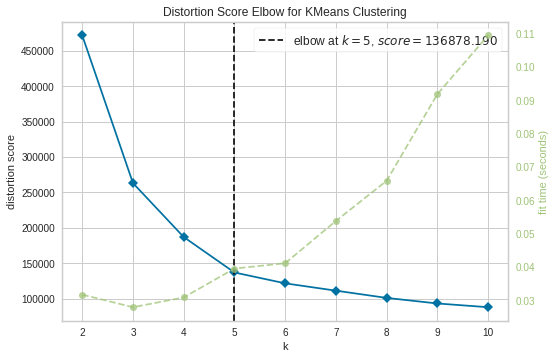

In [16]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=10)
visualizer.fit(eval)
visualizer.show()

Para K= 3


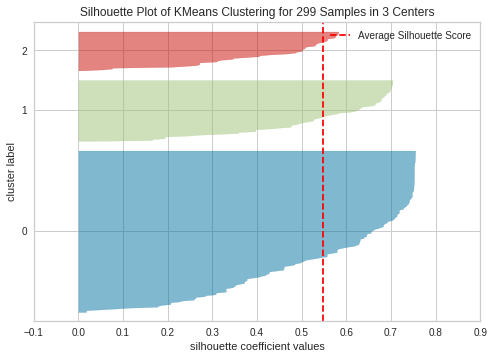

Para K= 4


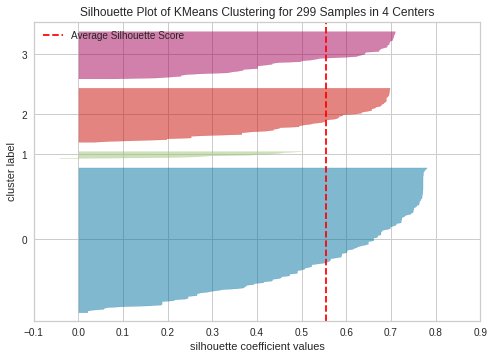

Para K= 5


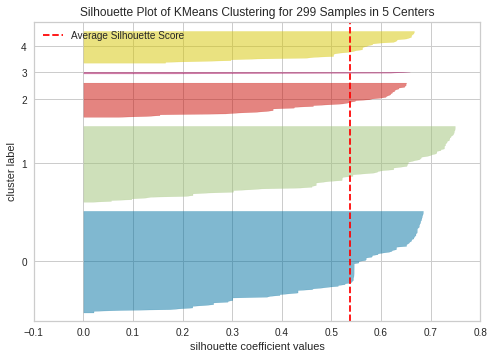

In [17]:
for i in range(3,6):
  print("Para K=",i)
  silhouette_visualizer(KMeans(i), heart_failure, colors='yellowbrick')

A partir de las visualizaciones anteriores, tomamos **k=5**
cuya justificación en la primer gráfica consiste en que 5 es donde sucede el cruce entre el número de k y la distorcióón del puntaje, si bajamos o aumentamos k, podemos obtener fallas en el puntaje. Asi mismo podemos ver que en el indice de silhouette, 5 forma 5 grupos que el algoritmo distingue perfectamente, por lo tanto. Tomamos **K=5**

## Formación de Clusters

In [18]:
result = KMeans(n_clusters=5,init='random',max_iter=200).fit(eval.drop('DEATH_EVENT',axis=1)) # para no entrenar con el target event
result

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=200, n_clusters=5,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=0)

In [19]:
result.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtyp

In [20]:
cluster_result = list(result.labels_)
eval = eval.assign(Cluster_group = cluster_result)
eval.head()

,age,ejection_fraction,serum_creatinine,time,DEATH_EVENT,Cluster_group
0,75.0,20,1.9,4,1,2
1,55.0,38,1.1,6,1,2
2,65.0,20,1.3,7,1,2
3,50.0,20,1.9,7,1,2
4,65.0,20,2.7,8,1,2


## Análisis

<a id="analisis"><h1><stron> Análisis de grupos </strong></h1></a>


In [21]:
cluster_1 = eval[eval['Cluster_group'] == 0]
cluster_1.mean()

age                   56.095238
ejection_fraction     38.380952
serum_creatinine       1.191190
time                 249.190476
DEATH_EVENT            0.047619
Cluster_group          0.000000
dtype: float64

**Cluster 1:** Probabilidad de muerte = 4%
En su mayoría este grupo esta compuesto por personas 
de 56 años. 
Enfoquemonos en los siguientes datos: 
  * age                   56.095238
  * ejection_fraction     38.380952
  * serum_creatinine       1.191190
  * time                  249.190476
  * DEATH_EVENT            0.047619

Para hacer la comparativa con los demás grupos. 

In [22]:
cluster_2 = eval[eval['Cluster_group'] == 1]
cluster_2.mean()

age                   60.031541
ejection_fraction     37.702703
serum_creatinine       1.372568
time                 196.932432
DEATH_EVENT            0.162162
Cluster_group          1.000000
dtype: float64

Cluster 2: Probabilidad de muerte = 16% 
En su mayoría este grupo esta compuesto por personas de 60 años.
Enfoquemonos en los siguientes datos:
  * age                   60.031541
  * ejection_fraction     37.702703
  * serum_creatinine       1.372568
  * time                  196.932432
  * DEATH_EVENT            0.162162
    
Para hacer la comparativa con los demás grupos.


In [23]:
cluster_3 = eval[eval['Cluster_group'] == 2]
cluster_3.mean()

age                  66.696429
ejection_fraction    36.232143
serum_creatinine      1.860536
time                 24.071429
DEATH_EVENT           0.892857
Cluster_group         2.000000
dtype: float64

Cluster 3: Probabilidad de muerte = 89% 
En su mayoría este grupo esta compuesto por personas de 66 años.
Enfoquemonos en los siguientes datos:
  * age                  66.696429
  * ejection_fraction    36.232143
  * serum_creatinine      1.860536
  * time                24.071429
  * DEATH_EVENT           0.892857
  
Para hacer la comparativa con los demás grupos.

In [24]:
cluster_4 = eval[eval['Cluster_group'] == 3]
cluster_4.mean()

age                   59.892857
ejection_fraction     39.303571
serum_creatinine       1.233036
time                 123.357143
DEATH_EVENT            0.178571
Cluster_group          3.000000
dtype: float64

Cluster 4: Probabilidad de muerte = 17% 
En su mayoría este grupo esta compuesto por personas de 59 años.
Enfoquemonos en los siguientes datos:
  * age                   59.892857
  * ejection_fraction     39.303571
  * serum_creatinine       1.233036
  * time                 123.357143
  * DEATH_EVENT            0.178571
  
Para hacer la comparativa con los demás grupos.

In [25]:
cluster_5 = eval[eval['Cluster_group'] == 4]
cluster_5.mean()

age                  60.591549
ejection_fraction    38.802817
serum_creatinine      1.294789
time                 79.619718
DEATH_EVENT           0.309859
Cluster_group         4.000000
dtype: float64

Cluster 5: Probabilidad de muerte = 30% 
En su mayoría este grupo esta compuesto por personas de 60 años.
Enfoquemonos en los siguientes datos:
  * age                  60.591549
  * ejection_fraction    38.802817
  * serum_creatinine      1.294789
  * time                79.619718
  * DEATH_EVENT           0.309859
  
Para hacer la comparativa con los demás grupos.

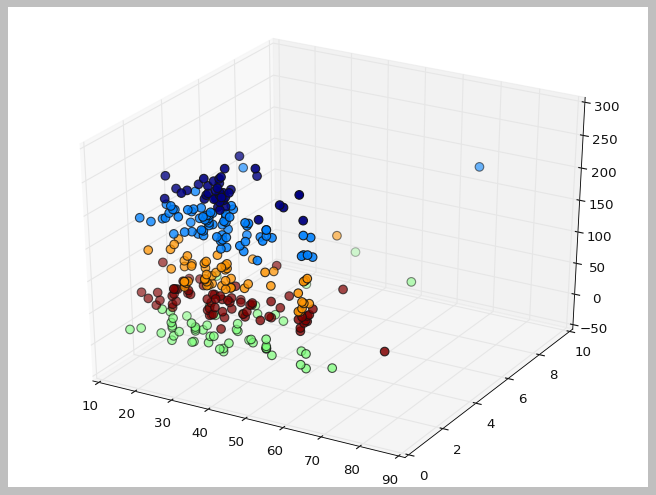

In [26]:
#graficamos las 3 dimensiones mas importantes

X = np.array(eval[['ejection_fraction','serum_creatinine','time']])

labels=np.array(eval['Cluster_group'])
plt.style.use('classic')

y = np.array(eval['DEATH_EVENT'])

fig = plt.figure()
ax=Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels,s=60)


Tenemos entonces 5 grupos, formados por las características previamente descritas. 
  
  
> Nota: **Es probable que si vuelven a correr todo el notebook, las
descripciones de cada cluster no correspondan. Pero no hay problema, simplemente cambiaron de cluster, es decir se formaron los mismos 5 clusters con las mismas caracteristicas, tal vez una ligera variación en algunos valores, pero son bastante cercanos**

<a id="serialexperimentslain"><h1><strong> Experimento </strong></h1></a>

# K-means sin elección de columnas

In [27]:
heart_failure.head

<bound method NDFrame.head of       age  anaemia  creatinine_phosphokinase  ...  smoking  time  DEATH_EVENT
0    75.0        0                       582  ...        0     4            1
1    55.0        0                      7861  ...        0     6            1
2    65.0        0                       146  ...        1     7            1
3    50.0        1                       111  ...        0     7            1
4    65.0        1                       160  ...        0     8            1
..    ...      ...                       ...  ...      ...   ...          ...
294  62.0        0                        61  ...        1   270            0
295  55.0        0                      1820  ...        0   271            0
296  45.0        0                      2060  ...        0   278            0
297  45.0        0                      2413  ...        1   280            0
298  50.0        0                       196  ...        1   285            0

[299 rows x 13 columns]>

In [28]:
result_without = KMeans(n_clusters=5,init='random',max_iter=200).fit(heart_failure.drop('DEATH_EVENT',axis=1)) # para no entrenar con el target event
result_without

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=200, n_clusters=5,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=None,
       tol=0.0001, verbose=0)

In [29]:
cluster_result_without = list(result_without.labels_)
heart_failure = heart_failure.assign(Cluster_group = cluster_result_without)
heart_failure.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,Cluster_group
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1,4
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1,3


In [30]:
cluster_1_without = heart_failure[heart_failure['Cluster_group'] == 0]
cluster_1_without.mean()

age                             60.518528
anaemia                          0.444444
creatinine_phosphokinase       582.638889
diabetes                         0.388889
ejection_fraction               38.611111
high_blood_pressure              0.388889
platelets                   406444.444444
serum_creatinine                 1.517500
serum_sodium                   137.638889
sex                              0.666667
smoking                          0.361111
time                           133.000000
DEATH_EVENT                      0.361111
Cluster_group                    0.000000
dtype: float64

In [31]:
cluster_2_without = heart_failure[heart_failure['Cluster_group'] == 1]
cluster_2_without.mean()

age                             61.460787
anaemia                          0.375000
creatinine_phosphokinase       658.705882
diabetes                         0.441176
ejection_fraction               38.264706
high_blood_pressure              0.330882
platelets                   239212.873162
serum_creatinine                 1.421029
serum_sodium                   136.080882
sex                              0.647059
smoking                          0.286765
time                           128.786765
DEATH_EVENT                      0.323529
Cluster_group                    1.000000
dtype: float64

In [32]:
cluster_3_without = heart_failure[heart_failure['Cluster_group'] == 2]
cluster_3_without.mean()

age                             55.40
anaemia                          0.20
creatinine_phosphokinase       668.60
diabetes                         0.80
ejection_fraction               43.00
high_blood_pressure              0.40
platelets                   657800.00
serum_creatinine                 1.22
serum_sodium                   137.80
sex                              0.20
smoking                          0.40
time                           183.20
DEATH_EVENT                      0.20
Cluster_group                    2.00
dtype: float64

In [33]:
cluster_4_without = heart_failure[heart_failure['Cluster_group'] == 3]
cluster_4_without.mean()

age                             60.149254
anaemia                          0.522388
creatinine_phosphokinase       508.985075
diabetes                         0.432836
ejection_fraction               38.358209
high_blood_pressure              0.402985
platelets                   305343.283582
serum_creatinine                 1.204478
serum_sodium                   136.880597
sex                              0.552239
smoking                          0.313433
time                           124.671642
DEATH_EVENT                      0.268657
Cluster_group                    3.000000
dtype: float64

In [34]:
cluster_5_without = heart_failure[heart_failure['Cluster_group'] == 4]
cluster_5_without.mean()

age                             60.818182
anaemia                          0.472727
creatinine_phosphokinase       472.109091
diabetes                         0.327273
ejection_fraction               36.509091
high_blood_pressure              0.309091
platelets                   142401.818182
serum_creatinine                 1.492364
serum_sodium                   136.890909
sex                              0.800000
smoking                          0.381818
time                           134.109091
DEATH_EVENT                      0.363636
Cluster_group                    4.000000
dtype: float64

Observamos que cuando no hay una selección de columnas de trabajo no hay mucha distinción entre los grupos.
Para evidenciar el problema, procedemos a hacer una comparativa entre experimentos.

# Para hacer la comparativa entre experimentos
vamos a tomar los dos grupos de mayor probabilidad 
de muerte, target event. Tanto para cuando hay selección de columnas como cuando no la hay.

> **Con elección de columnas tenemos:** 

> 1
- Age                  66.696429
- ejection_fraction    36.232143
- serum_creatinine      1.860536
- time                 24.071429
- DEATH_EVENT           0.892857

> 2 
- age                  60.591549
- ejection_fraction    38.802817
- serum_creatinine      1.294789
- time                 79.619718
- DEATH_EVENT           0.309859

>**Sin elección de columnas tenemos:** 

> 1 
- age                             60.818182
- anaemia                          0.472727
- creatinine_phosphokinase       472.109091
- diabetes                         0.327273
- ejection_fraction               36.509091
- high_blood_pressure              0.309091
- platelets                   142401.818182
- serum_creatinine                 1.492364
- serum_sodium                   136.890909
- sex                              0.800000
- smoking                          0.381818
- time                           134.109091
- DEATH_EVENT                      0.363636

> 2
- age                             60.518528
- anaemia                          0.444444
- creatinine_phosphokinase       582.638889
- diabetes                         0.388889
- ejection_fraction               38.611111
- high_blood_pressure              0.388889
- platelets                   406444.444444
- serum_creatinine                 1.517500
- serum_sodium                   137.638889
- sex                              0.666667
- smoking                          0.361111
- time                           133.000000
- DEATH_EVENT                      0.361111

> **Filtrando para quedar con las mismas columnas que los datos en los que si hubo selección de columnas tenemos:**

> 1
- age                             60.818182
- ejection_fraction               36.509091
- serum_creatinine                 1.492364
- time                           134.109091
- DEATH_EVENT                      0.363636

> 2
- age                             60.518528
- ejection_fraction               38.611111
- serum_creatinine                 1.517500
- time                           133.000000
- DEATH_EVENT                      0.361111

> Podemos observar que no hay mucha distinción en los datos cuando no se hace selección de columnas como para poder obtener conocimiento sobre algo. En cambio cuando hay selección de columnas de trabajo a partir de la correlación con el target event, obtenemos una clara distinción de los grupos. 
Esto justifica el uso de la matriz de correlación usada anteriormente para poder justificar la eliminación de algunas columnas a la hora de trabajar. 